<a href="https://colab.research.google.com/github/KeeJin/babies_emotion_detector/blob/master/Babies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Baby Emotion Detector
###by Cheo Kee Jin

##Emotions covered by model
*   Happy
*   Sad
*Angry

Note: model results might be affected by the rather small dataset collected, especially for photos of sad and angry babies



##Set-up

In [ ]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 372.4MB 92kB/s 
     |████████████████████████████████| 450kB 41.5MB/s 
     |████████████████████████████████| 61kB 18.8MB/s 
     |████████████████████████████████| 3.9MB 30.9MB/s 


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/MA2071/ ')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Creation of Dataframe

In [ ]:
import os
import pandas as pd

path = "drive/My Drive/Dataset"

data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
df.dtypes

                                            filename  class_name  class
0  /content/drive/My Drive/Dataset/Angry baby/pic...  Angry baby      0
1  /content/drive/My Drive/Dataset/Angry baby/pic...  Angry baby      0
2  /content/drive/My Drive/Dataset/Angry baby/pic...  Angry baby      0
3  /content/drive/My Drive/Dataset/Angry baby/pic...  Angry baby      0
4  /content/drive/My Drive/Dataset/Happy baby/pic...  Happy baby      1


filename        object
class_name    category
class             int8
dtype: object

In [ ]:
total_dataset_size = len(df)

In [ ]:
# Split into train and validation sets
train_set_percentage = .9

df = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

#shuffle
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head(10)

,filename,class_name,class
0,/content/drive/My Drive/Dataset/Angry baby/pic...,Angry baby,0
1,/content/drive/My Drive/Dataset/Angry baby/pic...,Angry baby,0
2,/content/drive/My Drive/Dataset/Angry baby/pic...,Angry baby,0
3,/content/drive/My Drive/Dataset/Happy baby/pic...,Happy baby,1
4,/content/drive/My Drive/Dataset/Sad baby/image...,Sad baby,2
5,/content/drive/My Drive/Dataset/Happy baby/pic...,Happy baby,1
6,/content/drive/My Drive/Dataset/Angry baby/pic...,Angry baby,0
7,/content/drive/My Drive/Dataset/Sad baby/image...,Sad baby,2
8,/content/drive/My Drive/Dataset/Happy baby/pic...,Happy baby,1
9,/content/drive/My Drive/Dataset/Angry baby/pic...,Angry baby,0


In [ ]:
print(df.shape)
print(df_val.shape)

print(df['class'].unique())
print(df["class_name"].value_counts())

(662, 3)
(67, 3)
[0 1 2]
Angry baby    304
Happy baby    221
Sad baby      137
Name: class_name, dtype: int64


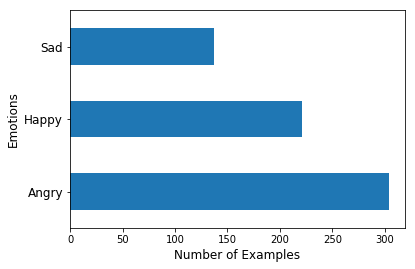

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = df['class_name'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Emotions", fontsize=12)
ax.set_yticklabels(['Angry','Happy','Sad'], rotation=0, fontsize=12)
plt.show()

In [ ]:
num_classes = 3

df.shape

(662, 3)

##Image Pipeline

In [ ]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

##Data Pipeline

In [ ]:
babies_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
babies_dataset= babies_dataset.map(_parse_function)
babies_dataset = babies_dataset.shuffle(1000)
babies_dataset = babies_dataset.repeat(100)
babies_dataset = babies_dataset.batch(32, drop_remainder = True)

babies_dataset

<BatchDataset shapes: ((32, 224, 224, 3), (32, 3)), types: (tf.float32, tf.float32)>

In [ ]:

valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(100).shuffle(1000)
valid_dataset = valid_dataset.batch(32)


##Importing Pre-trained Model

In [ ]:
import tensorflow as tf
import math

from tensorflow.keras import optimizers

from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, LearningRateScheduler

In [ ]:
# create the base pre-trained model
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3), pooling = None)

58892288/58889256 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

##Adding Extra Layers To Model

In [ ]:
x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

predictions = Dense(3, activation='softmax')(x)


##Defining Model and Freezing Layers in Pre-trained Model

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_1  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_pool  Trainable = False
global_average_pooling2d  Trainable = True
dense  Trainable = True
dropout  Trainable = True
dense_1  Trainable = True


In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

##Optimiser

In [ ]:
opt = optimizers.SGD(lr=0.0005)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

##Initialise Training and Validation Phase



In [ ]:
train_steps = int((total_dataset_size*0.9)/32) #total trains set / batch_size
val_steps = int((total_dataset_size*0.1)/32)
epochs = 50

###Set the Learning Rate to drop every 3 Epochs

In [ ]:
def LRDropping(epoch_number):
    initial_lrate = 0.005
    drop = 0.9
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch_number)/epochs_drop))
    print(lrate)
    return lrate

In [ ]:
LRDrop = LearningRateScheduler(LRDropping)

##Callbacks

###Creation of Model Checkpoint

In [ ]:
!mkdir checkpoints

In [ ]:
!ls
checkpoint = ModelCheckpoint('./checkpoints/new_weights_{epoch:02d}_{val_accuracy:.2f}.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

checkpoints  drive  sample_data


###Early Stopping if Valence loss does not change for 5 consecutive Epochs

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=5,verbose=0,mode='auto')

##Model Fitting

In [ ]:
history = model.fit( babies_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks = [LRDrop, early_stopping, checkpoint])

0.005
Epoch 1/50


W0718 06:41:04.610926 140302637545344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0718 06:41:04.728708 140302637545344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:468: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


19/20 [===========================>..] - ETA: 18s - loss: 4.3626 - accuracy: 0.4556
Epoch 00001: val_accuracy improved from -inf to 0.65625, saving model to ./checkpoints/new_weights_01_0.66.hdf5
20/20 [==============================] - 359s 18s/step - loss: 4.2345 - accuracy: 0.4625 - val_loss: 1.9771 - val_accuracy: 0.6562
0.005
Epoch 2/50
19/20 [===========================>..] - ETA: 0s - loss: 2.2013 - accuracy: 0.5691
Epoch 00002: val_accuracy improved from 0.65625 to 0.67188, saving model to ./checkpoints/new_weights_02_0.67.hdf5
20/20 [==============================] - 11s 567ms/step - loss: 2.1610 - accuracy: 0.5688 - val_loss: 1.0563 - val_accuracy: 0.6719
0.0045000000000000005
Epoch 3/50
19/20 [===========================>..] - ETA: 0s - loss: 1.1565 - accuracy: 0.6562
Epoch 00003: val_accuracy improved from 0.67188 to 0.71875, saving model to ./checkpoints/new_weights_03_0.72.hdf5
20/20 [==============================] - 11s 568ms/step - loss: 1.1637 - accuracy: 0.6531 - val

##Fine-tuning the Model

###Set Block 5 of Network to be Trainable

In [ ]:
model.trainable = True

# set_trainable = False
for layer in model.layers:
    if layer.name != 'block5_conv1':
        layer.trainable = False
    else:
        break

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_average_pooling2d True
dense True
dropout True
dense_1 True


##Compile Model again

In [ ]:
history = model.fit( babies_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks = [LRDrop, early_stopping, checkpoint])

0.005
Epoch 1/50


W0718 06:50:38.158430 140302637545344 training.py:1968] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


19/20 [===========================>..] - ETA: 0s - loss: 0.1372 - accuracy: 0.9688
Epoch 00001: val_accuracy did not improve from 1.00000
20/20 [==============================] - 15s 731ms/step - loss: 0.1348 - accuracy: 0.9703 - val_loss: 0.0590 - val_accuracy: 1.0000
0.005
Epoch 2/50
19/20 [===========================>..] - ETA: 0s - loss: 0.1533 - accuracy: 0.9556
Epoch 00002: val_accuracy did not improve from 1.00000
20/20 [==============================] - 11s 560ms/step - loss: 0.1558 - accuracy: 0.9531 - val_loss: 0.0514 - val_accuracy: 1.0000
0.0045000000000000005
Epoch 3/50
19/20 [===========================>..] - ETA: 0s - loss: 0.1575 - accuracy: 0.9474
Epoch 00003: val_accuracy did not improve from 1.00000
20/20 [==============================] - 11s 559ms/step - loss: 0.1573 - accuracy: 0.9469 - val_loss: 0.0529 - val_accuracy: 1.0000
0.0045000000000000005
Epoch 4/50
19/20 [===========================>..] - ETA: 0s - loss: 0.1525 - accuracy: 0.9474
Epoch 00004: val_accurac

In [ ]:
metrics = model.evaluate(valid_dataset,
                        steps = val_steps)
print("model accuracy:", metrics[1])

2/2 [==============================] - 3s 2s/step - loss: 0.0205 - accuracy: 1.0000
model accuracy: 1.0


##A Little Fun - we test our model on a kid

###Getting User to Input URL Link

In [ ]:
user_photo = str(input("Weblink to photo: "))


Weblink to photo: http://mlwilson.pbworks.com/f/1255737310/preschooler.jpg


In [ ]:
import urllib.request
from IPython.display import Image


while True:
  try:
    urllib.request.urlretrieve(user_photo, "testbaby1.jpg")
    break
  except:
    print("There is something wrong with the link you provided. Please try again!\n")
    user_photo = str(input("Weblink to photo: "))

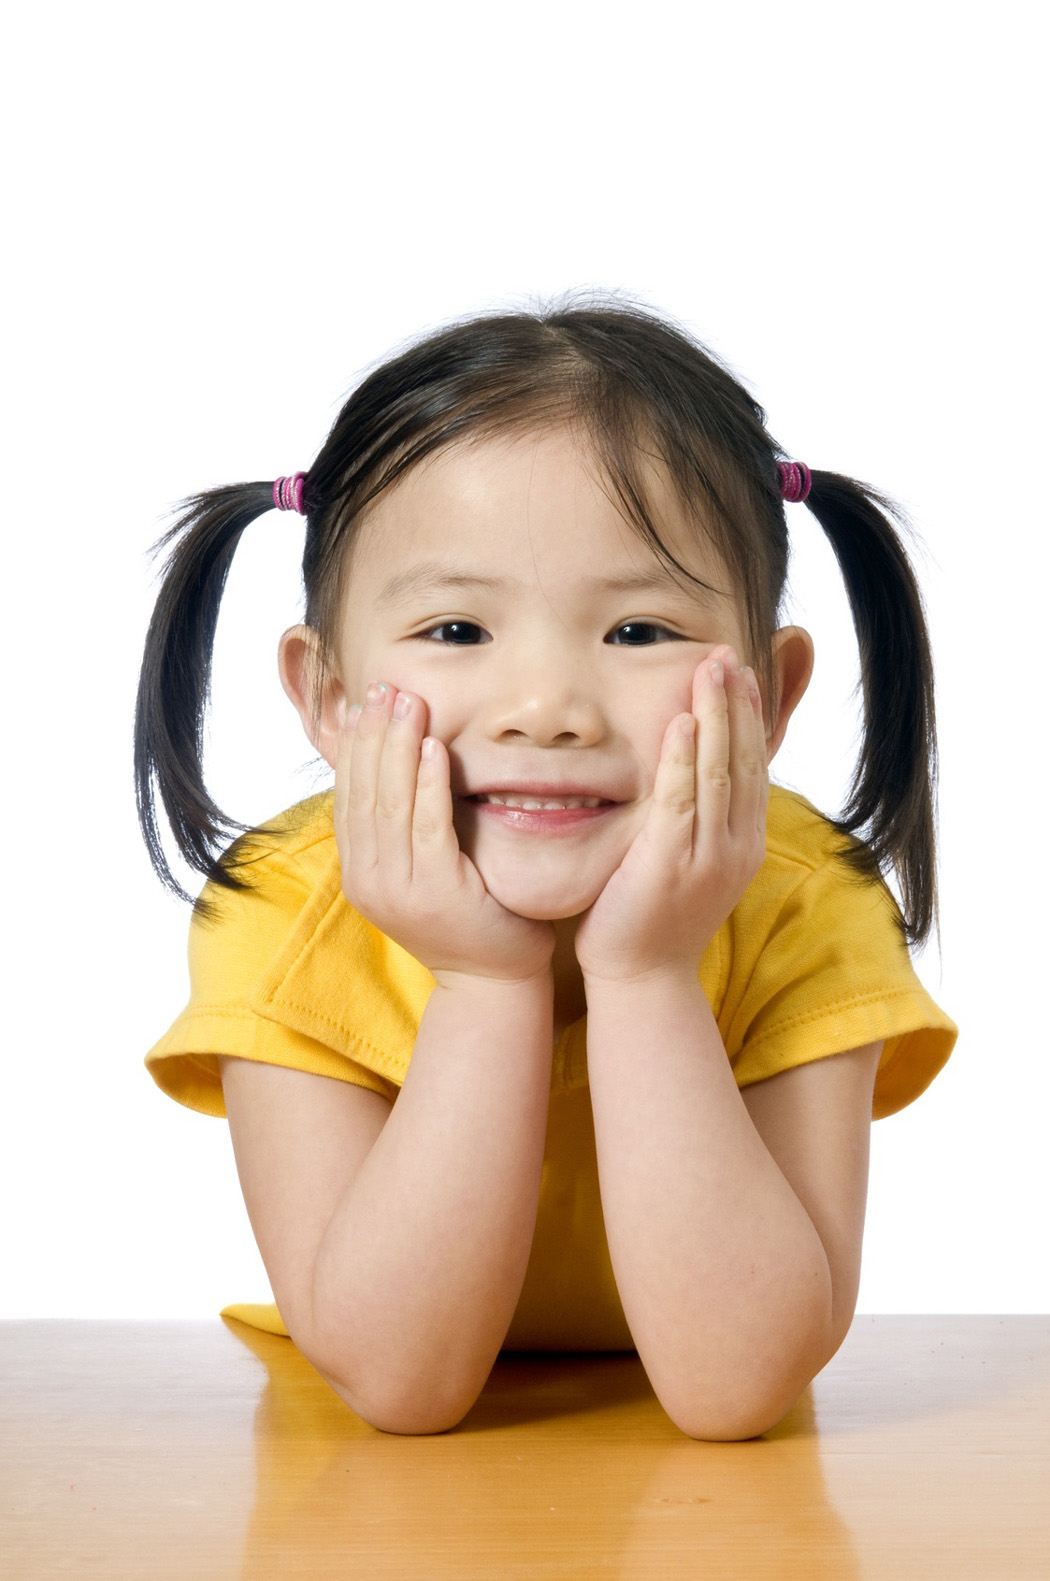

In [ ]:
Image("testbaby1.jpg")

###Image Processing

In [ ]:
import numpy as np
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

img = image.load_img("testbaby1.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


###Prediction

In [ ]:
preds = model.predict(x)
print('Predicted:', preds)


Predicted: [[3.1837285e-03 9.9657094e-01 2.4536869e-04]]


In [ ]:
emo = ["Angry", "Happy", "Sad"]
pred = max(preds[0])
for y in range (0,3):
  if pred == preds[0][y]:
    print ("This baby is feeling {}!".format(emo[y]))

This baby is feeling Happy!
